
This project's main goal is to **predict the winning political parties in each postal area where elections are held**. The major political party will be considered for this task: **Liberals**. In the event that a second party (for instance, labor, greens or other) wins, it will be counted as 'others.'

**In essence, the question we are willing to answer is: Is sociodemographic status a predictor of liberal vote?**

Two types of data will be used to attain this goal: **census socio-demographic data** as predictors; and **official election 2019 results** as target variable. Usually, the outcome of the previous election is the strongest predictor of the upcoming vote (votes do not change that much). However, in this scenario, we will simply use sociodemographic factors for forecasting.

These two sets of data will be linked and evaluated in order to look for patterns and trends that can be used to predict vote outcomes. Information from the following sources will be used for this task:

* Australian Electoral Comission: https://results.aec.gov.au/24310/Website/HouseDownloadsMenu-24310-Csv.htm
* Austrlian Bureau of Statistics: https://www.abs.gov.au/statistics/microdata-tablebuilder/tablebuilder

<br>

Description of Fields: 

* **Age:** age of citizens living in POAS.
* **Household Income (weekly):** The experimental Index of Household Advantage and Disadvantage (IHAD) summarises relative socio-economic advantage and disadvantage for households. This index takes into account income, tenure type, families characteristics, etc.
* **Occupation:** standard output for occupation data in a major level of classification for citizens aged 15 years or over.
* **Education:** Max level of education reached.
* **Rural or Uban**: Proportion of dwellings in rural / urban areas.

<br>

**As this is a classification ask**, two models are going to be used for forecasting first preference vote: K-Nearest-Neighbors and Logistic Regression.

In [1]:
# Import necesary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# DATA PREPARATION

## ELECTORAL DATASET

### Importing data

In [2]:
# Funtion to load and pivot electoral results

def load_elec_results(path_to_data):
    
    '''Reads a csv with electoral results and returns an 
    pivoted dataframe with postal codes in rows and party votes in columns'''
    
    data = pd.read_csv(path_to_data, skiprows = 1)
    
    data = data[['StateAb', 'DivisionID', 'DivisionNm', 'PollingPlaceID', 'PollingPlace', 
                 'PartyAb', 'OrdinaryVotes']] # Select columns to keep
    
    table = pd.pivot_table(data, values='OrdinaryVotes', 
                           index=['StateAb', 'DivisionID', 'DivisionNm', 'PollingPlaceID', 'PollingPlace'], 
                           columns=['PartyAb'], aggfunc = np.sum).reset_index() # Pivot table to reorder the data
    
    table.drop(columns = ['StateAb', 'DivisionID', 
                          'DivisionNm'], inplace = True) # Drop geographical columns that will not be used

                                
    return table
    

In [3]:
# Load first preference electoral results for all states

act = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/ACT.csv')
nsw = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/NSW.csv')
nt = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/NT.csv')
qld = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/QLD.csv')
sa = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/SA.csv')
tas = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/TAS.csv')
vic = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/VIC.csv')
wa = load_elec_results('files/portolio_4_datasets/first_pref_results_2019/WA.csv')

In [4]:
# Concatenation of all states

states_data = pd.concat([act, nsw, nt, qld, sa, tas, vic, wa], ignore_index = True, sort = False)
states_data.head(3)

PartyAb,PollingPlaceID,PollingPlace,ALP,AUP,GAP,GRN,IND,LDP,LP,UAPP,...,AUD,CPP,XEN,CEC,DHJP,REAS,VNS,AUC,FLUX,WAP
0,8764,Curtin (Canberra),867.0,55.0,NaN,423.0,102.0,NaN,506.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8766,Deakin,343.0,16.0,NaN,159.0,36.0,NaN,564.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8774,Hughes (Canberra),597.0,30.0,NaN,286.0,74.0,NaN,466.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Group parties by main coalitions according to analysis porposes

states_data['Liberal'] = states_data[['LP', 'LNP', 'NP', 'CLP']].sum(axis = 1)

states_data.drop(columns = ['LP', 'LNP', 'NP', 'CLP'], inplace = True)
states_data.head()

PartyAb,PollingPlaceID,PollingPlace,ALP,AUP,GAP,GRN,IND,LDP,UAPP,ABFA,...,CPP,XEN,CEC,DHJP,REAS,VNS,AUC,FLUX,WAP,Liberal
0,8764,Curtin (Canberra),867.0,55.0,NaN,423.0,102.0,NaN,32.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.0
1,8766,Deakin,343.0,16.0,NaN,159.0,36.0,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,564.0
2,8774,Hughes (Canberra),597.0,30.0,NaN,286.0,74.0,NaN,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466.0
3,8779,Lyons (Canberra),350.0,18.0,NaN,177.0,58.0,NaN,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.0
4,8782,Narrabundah,632.0,17.0,NaN,271.0,64.0,NaN,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.0


In [6]:
# Groub electoral data by Polling Place ID

elec_data = states_data.groupby(['PollingPlaceID']).sum().reset_index()
elec_data.head()

PartyAb,PollingPlaceID,ALP,AUP,GAP,GRN,IND,LDP,UAPP,ABFA,AFN,...,CPP,XEN,CEC,DHJP,REAS,VNS,AUC,FLUX,WAP,Liberal
0,1,917.0,0.0,0.0,111.0,0.0,0.0,87.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,619.0
1,2,423.0,0.0,0.0,68.0,0.0,0.0,42.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.0
2,3,501.0,0.0,0.0,52.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463.0
3,4,657.0,0.0,0.0,134.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1644.0
4,5,676.0,0.0,0.0,101.0,0.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,909.0


### Cleaning data

In [7]:
elec_data.shape

(8875, 38)

In [8]:
#Check for NaN values

elec_data.isnull().values.any()

False

In [9]:
elec_data.describe()

PartyAb,PollingPlaceID,ALP,AUP,GAP,GRN,IND,LDP,UAPP,ABFA,AFN,...,CPP,XEN,CEC,DHJP,REAS,VNS,AUC,FLUX,WAP,Liberal
count,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,...,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000,8875.000000
mean,24194.546366,451.391775,0.753690,0.505014,134.274479,46.445070,3.185465,44.739718,0.190535,0.621408,...,0.102085,4.567775,0.307606,2.242592,0.777690,1.244732,2.169577,0.047887,2.104563,550.709746
std,29774.333482,735.335782,8.349528,5.965838,207.969899,199.536291,24.838547,86.989184,4.053324,13.921218,...,1.895498,70.084604,9.636136,20.151647,12.007831,17.708233,12.375555,0.981038,12.157542,902.883689
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3478.500000,82.000000,0.000000,0.000000,21.000000,0.000000,0.000000,10.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,145.000000
50%,7221.000000,281.000000,0.000000,0.000000,79.000000,0.000000,0.000000,24.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000
75%,34137.000000,573.000000,0.000000,0.000000,167.000000,29.000000,0.000000,49.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622.000000
max,97639.000000,12402.000000,449.000000,332.000000,5289.000000,5730.000000,1070.000000,2170.000000,231.000000,998.000000,...,110.000000,4323.000000,773.000000,702.000000,698.000000,955.000000,474.000000,60.000000,441.000000,10490.000000


**Electoral data seems cleaned**. The distribution of the data is logical, either outliers or values are observed.

### Import and impute POAS (postal areas) to elec_data

In [10]:
# Load dataset of POA (postalcodes) and merge it with electoral data

poa_data = pd.read_csv('files/portolio_4_datasets/Polling_places.csv', skiprows = 1, 
                       usecols = ['PollingPlaceID', 'PremisesPostCode'])

poa_data.rename(columns = {'PremisesPostCode':'POA'}, inplace = True)

poa_data.head()

,PollingPlaceID,POA
0,93925,2900.0
1,93927,2601.0
2,11877,2905.0
3,11452,2905.0
4,8761,2611.0


In [11]:
# Link postalcodes to electoral data

elec_data = pd.merge(left = poa_data, right = elec_data, on = "PollingPlaceID", how = 'inner')


print('Electoral data shape: ', states_data.shape)
print('Polling place data shape: ', poa_data.shape)
print('Merged data shape: ', elec_data.shape)

Electoral data shape:  (8875, 39)
Polling place data shape:  (8875, 2)
Merged data shape:  (8875, 39)


In [12]:
# Group by POAS adding up votes

elec_data = elec_data.groupby(['POA']).agg(np.sum).reset_index()
elec_data.drop(columns = ['PollingPlaceID'], inplace = True)
elec_data.head()

,POA,ALP,AUP,GAP,GRN,IND,LDP,UAPP,ABFA,AFN,...,CPP,XEN,CEC,DHJP,REAS,VNS,AUC,FLUX,WAP,Liberal
0,800.0,3642.0,0.0,0.0,1090.0,451.0,0.0,243.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4291.0
1,810.0,7277.0,0.0,0.0,2280.0,632.0,0.0,402.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5690.0
2,812.0,2767.0,0.0,0.0,591.0,273.0,0.0,169.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1885.0
3,820.0,1765.0,0.0,0.0,711.0,202.0,0.0,93.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1823.0
4,822.0,2002.0,0.0,0.0,146.0,81.0,0.0,59.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1006.0


In [13]:
# Check for NaN values

elec_data.isnull().values.any()

False

In [14]:
#Check for data without POA - postcode

print('% of data without a postalcode: ', (elec_data['POA'].isnull().sum() / len(elec_data))*100)

% of data without a postalcode:  0.0


### Impute codes to winners

In [15]:
# Compute and recode target variable

cols = ['ALP', 'AUP', 'GAP', 'GRN', 'IND', 'LDP', 'UAPP',
       'ABFA', 'AFN', 'AJP', 'ASP', 'AWP', 'CDP', 'FACN', 'FUT', 'IMO', 'NCP',
       'ON', 'SEP', 'SPP', 'RUA', 'DLP', 'KAP', 'LAOL', 'NAFD', 'SAL', 'AUD',
       'CPP', 'XEN', 'CEC', 'DHJP', 'REAS', 'VNS', 'AUC', 'FLUX', 'WAP',
       'Liberal']

elec_data["Winner"] = elec_data[cols].idxmax(axis = 1)

elec_data = elec_data[['POA', 'Winner']]
elec_data.head()

,POA,Winner
0,800.0,Liberal
1,810.0,ALP
2,812.0,ALP
3,820.0,Liberal
4,822.0,ALP


In [16]:
# Aplly lambda function to recode winners

largest_num = lambda x: 1 if x == 'Liberal' else 0

elec_data['win_code'] = elec_data['Winner'].apply(largest_num)

elec_data = elec_data[['POA', 'win_code']]

elec_data.head()

,POA,win_code
0,800.0,1
1,810.0,0
2,812.0,0
3,820.0,1
4,822.0,0


In [17]:
round(elec_data[['win_code']].value_counts()/len(elec_data)*100,1)

win_code
1           70.7
0           29.3
dtype: float64

<br>

**Codes:**

0 -> Liberal <br>
1 -> Labor <br>
2 -> Greens <br>
3 -> Others <br>

<br>

## SOCIO DEMOGRAPHIC DATASET

### AGE data

#### Importing data

In [18]:
# Load dataframe

age_data = pd.read_csv('files/portolio_4_datasets/census_features/age_POA.csv', skiprows = 9, 
                       usecols = ['POA (UR)', 'AGEP Age', 'Count'])
age_data.drop(index = age_data.index[0], axis = 0, inplace = True)
age_data.head()

,POA (UR),AGEP Age,Count
1,"2000, NSW",1.0,174.0
2,"2000, NSW",2.0,145.0
3,"2000, NSW",3.0,113.0
4,"2000, NSW",4.0,93.0
5,"2000, NSW",5.0,78.0


Age data presents a different structure. Each POA has multiple observations, each of which corresponds to a specific age and the amount of persons with that age. **The dataframe must be reorganised before using this information.**

The purpose of the following code is to compute the mean age for each POA. This feature is going to be used in the model.

In [19]:
# Extract POA code without state acronym
age_data['POA'] = age_data['POA (UR)'].str.extract('(\d{4,})')

# Compute sum of years per year (this computation will help to extract the mean age of every POA)
age_data["total_years"] = age_data['AGEP Age'] * age_data['Count']
age_data.head()

,POA (UR),AGEP Age,Count,POA,total_years
1,"2000, NSW",1.0,174.0,2000,174.0
2,"2000, NSW",2.0,145.0,2000,290.0
3,"2000, NSW",3.0,113.0,2000,339.0
4,"2000, NSW",4.0,93.0,2000,372.0
5,"2000, NSW",5.0,78.0,2000,390.0


#### Computing Mean age

In [20]:
# Group age data by POA adding up age
age_data = age_data.groupby(['POA'])[['Count', 'total_years']].sum().reset_index()


# Calculate mean age for each POA
age_data['age_mean'] = age_data['total_years'] / age_data['Count']
age_data.head()

,POA,Count,total_years,age_mean
0,0800,6478.0,229368.0,35.407224
1,0810,33317.0,1168519.0,35.072756
2,0812,18865.0,666452.0,35.327432
3,0815,300.0,8022.0,26.740000
4,0820,19467.0,705418.0,36.236606


#### Cleaning AGE data

In [21]:
age_data[age_data['age_mean'].isnull()]

,POA,Count,total_years,age_mean
139,2123,0.0,0.0,NaN
144,2129,0.0,0.0,NaN
738,3062,0.0,0.0,NaN
1385,4009,0.0,0.0,NaN
1498,4222,0.0,0.0,NaN
1604,4475,0.0,0.0,NaN
1823,5005,0.0,0.0,NaN
2146,5701,0.0,0.0,NaN
2150,5717,0.0,0.0,NaN
2162,5950,0.0,0.0,NaN


NaN mean values correspond to observations that have no age information. This observations will be dropped.

In [22]:
# Drop observations with no data

age_data.dropna(inplace = True)
age_data.isnull().sum()

POA            0
Count          0
total_years    0
age_mean       0
dtype: int64

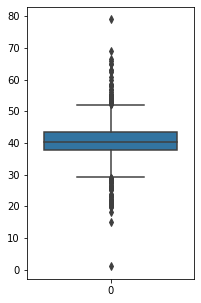

In [23]:
# Check for outliers

plt.figure(figsize = (3, 5))
sns.boxplot(data = age_data['age_mean'])
plt.show()

<br>

The boxplot above reveals the presence of outliers. While low population density may result in POAs with relatively low or high median ages, **POAs with mean ages under 28 or above 55 are extremely uncommon**. These outliers will be dropped.

<br>

In [24]:
# Drop observations where mean age is under 20 or above 60
age_data = age_data[(age_data['age_mean'] < 55) & (age_data['age_mean'] > 28)]


#Select columns of interest for the model
age_data = age_data[['POA', 'age_mean']]
age_data.shape

(2589, 2)

### HOUSEHOLD INDEX data

#### Importing data

In [25]:
# Load dataframe
hi_data = pd.read_csv('files/portolio_4_datasets/census_features/Exp_IHAD.csv', skiprows = 8,
                      usecols = ['IRSAD Deciles (Household)', 'Decile 1', 'Decile 2', 'Decile 3', 
                                 'Decile 4', 'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8', 'Decile 9', 'Decile 10'])
                       
hi_data.drop(index = hi_data.index[0], axis = 0, inplace = True)


# Extract POA code without state acronym
hi_data['IRSAD Deciles (Household)'] = hi_data['IRSAD Deciles (Household)'].str.extract('(\d{4,})')
hi_data.rename(columns = {'IRSAD Deciles (Household)': 'POA'}, inplace = True)


# Compute total for deciles
hi_data['total'] = hi_data.sum(axis = 1, numeric_only = True)

hi_data.head()

,POA,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10,total
1,2000,354,850.0,1404.0,1164.0,806.0,1629.0,964.0,1146.0,483.0,255.0,8701.0
2,2006,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2007,299,361.0,476.0,321.0,242.0,420.0,215.0,303.0,135.0,70.0,2543.0
4,2008,490,681.0,742.0,327.0,371.0,573.0,371.0,539.0,261.0,148.0,4013.0
5,2009,402,293.0,421.0,453.0,414.0,717.0,722.0,1114.0,478.0,330.0,4942.0


#### Cleaning HI data

In [26]:
# Check for null values

hi_data.isnull().sum()

POA          4
Decile 1     2
Decile 2     3
Decile 3     3
Decile 4     3
Decile 5     3
Decile 6     3
Decile 7     3
Decile 8     3
Decile 9     3
Decile 10    3
total        0
dtype: int64

In [27]:
# Drop NaN values

hi_data.dropna(inplace = True)
hi_data.isnull().values.any()

False

In [28]:
# Check for empty values

hi_data[hi_data['total'] == 0].shape

(57, 12)

In [29]:
#Discard POAS with no HouseHold Index values

hi_data = hi_data[hi_data['total'] != 0]

In [30]:
# Check for data types

hi_data.dtypes

POA           object
Decile 1      object
Decile 2     float64
Decile 3     float64
Decile 4     float64
Decile 5     float64
Decile 6     float64
Decile 7     float64
Decile 8     float64
Decile 9     float64
Decile 10    float64
total        float64
dtype: object

In [31]:
# Convert columns to numeric
cols = ['Decile 1', 'Decile 2', 'Decile 3', 'Decile 4', 'Decile 5',
       'Decile 6', 'Decile 7', 'Decile 8', 'Decile 9', 'Decile 10']

for c in cols:
    hi_data[c] = hi_data[c].astype(int)
    
hi_data['Decile 1'].dtype

dtype('int64')

In [32]:
# Compute proportions of deciles for each POA

cols = ['Decile 1', 'Decile 2', 'Decile 3', 'Decile 4', 'Decile 5',
       'Decile 6', 'Decile 7', 'Decile 8', 'Decile 9', 'Decile 10']

for c in cols:
    hi_data[c] = hi_data[c]/hi_data['total']
    

hi_data.drop(columns = 'total', inplace = True)
    
hi_data.head()

,POA,Decile 1,Decile 2,Decile 3,Decile 4,Decile 5,Decile 6,Decile 7,Decile 8,Decile 9,Decile 10
1,2000,0.040685,0.097690,0.161361,0.133778,0.092633,0.187220,0.110792,0.131709,0.055511,0.029307
3,2007,0.117578,0.141958,0.187180,0.126229,0.095163,0.165159,0.084546,0.119151,0.053087,0.027527
4,2008,0.122103,0.169698,0.184899,0.081485,0.092450,0.142786,0.092450,0.134313,0.065039,0.036880
5,2009,0.081344,0.059288,0.085188,0.091663,0.083772,0.145083,0.146095,0.225415,0.096722,0.066775
6,2010,0.125809,0.075430,0.099094,0.054816,0.106489,0.175171,0.117489,0.207062,0.095766,0.068682


#### Feature engineering

In [33]:
# We cant compute quintiles from raw data, so deciles will be merged to reduce complexity of model

hi_data['Deciles_1_2'] = hi_data['Decile 1'] + hi_data['Decile 2']
hi_data['Deciles_3_4'] = hi_data['Decile 3'] + hi_data['Decile 4']
hi_data['Deciles_5_6'] = hi_data['Decile 5'] + hi_data['Decile 6']
hi_data['Deciles_6_8'] = hi_data['Decile 7'] + hi_data['Decile 8']
hi_data['Deciles_9_10'] = hi_data['Decile 9'] + hi_data['Decile 10']

hi_data = hi_data[['POA', 'Deciles_1_2', 'Deciles_3_4', 'Deciles_5_6',
                  'Deciles_6_8', 'Deciles_9_10']]

hi_data.head()

,POA,Deciles_1_2,Deciles_3_4,Deciles_5_6,Deciles_6_8,Deciles_9_10
1,2000,0.138375,0.295138,0.279853,0.242501,0.084818
3,2007,0.259536,0.313409,0.260322,0.203696,0.080613
4,2008,0.291802,0.266384,0.235235,0.226763,0.101919
5,2009,0.140631,0.176851,0.228855,0.371510,0.163497
6,2010,0.201239,0.153910,0.281660,0.324552,0.164448


### OCCUPATION data

#### Importing data

In [34]:
# Load dataframe

occ_data = pd.read_csv('files/portolio_4_datasets/census_features/Occupation_POA.csv', 
                       skiprows = 8, usecols = ['POA (UR)', 'OCCP - 1 Digit Level', 'Count'])


# Extract POA code without state acronym

occ_data['POA (UR)'] = occ_data['POA (UR)'].str.extract('(\d{4,})')
occ_data.rename(columns = {'POA (UR)': 'POA'}, inplace = True)

occ_data.head()

,POA,OCCP - 1 Digit Level,Count
0,2000,Managers,2183.0
1,2000,Professionals,3820.0
2,2000,Technicians and Trades Workers,1690.0
3,2000,Community and Personal Service Workers,2474.0
4,2000,Clerical and Administrative Workers,1307.0


In [35]:
# Pivot table

occ_data = pd.pivot_table(occ_data, values = 'Count', 
                           index=['POA'], 
                           columns=['OCCP - 1 Digit Level'], 
                          aggfunc = np.sum).reset_index() # Pivot table to reorder the data


# Drop not stated and not applicable columns

occ_data.drop(columns = ['Not applicable', 'Not stated', 'Inadequately described', 'Total'], inplace = True)


# Compute total for deciles
occ_data['total'] = occ_data.sum(axis = 1, numeric_only = True)

occ_data.head()

OCCP - 1 Digit Level,POA,Clerical and Administrative Workers,Community and Personal Service Workers,Labourers,Machinery Operators and Drivers,Managers,Professionals,Sales Workers,Technicians and Trades Workers,total
0,0800,483.0,542.0,368.0,134.0,652.0,955.0,240.0,624.0,3998.0
1,0810,2224.0,2185.0,1508.0,832.0,1954.0,4431.0,1338.0,2328.0,16800.0
2,0812,1563.0,1135.0,925.0,586.0,1010.0,1774.0,778.0,1507.0,9278.0
3,0815,5.0,23.0,33.0,16.0,3.0,9.0,24.0,4.0,117.0
4,0820,1536.0,1243.0,721.0,356.0,1886.0,2762.0,731.0,1773.0,11008.0


#### Cleaning OCCUP data

In [36]:
# Check for null values

occ_data.isnull().sum()

OCCP - 1 Digit Level
POA                                       0
Clerical and Administrative Workers       0
Community and Personal Service Workers    0
Labourers                                 0
Machinery Operators and Drivers           0
Managers                                  0
Professionals                             0
Sales Workers                             0
Technicians and Trades Workers            0
total                                     0
dtype: int64

In [37]:
# Check for empty observations

occ_data[occ_data['total'] == 0].shape

(21, 10)

In [38]:
# Drop observations that have no values

occ_data = occ_data[occ_data['total'] != 0]

#### Feature engineering

In [39]:
occ_data['State_and_admin'] = occ_data['Clerical and Administrative Workers'] + \
                                  occ_data['Community and Personal Service Workers']

occ_data['Labourers'] = occ_data['Labourers'] + occ_data['Machinery Operators and Drivers']

occ_data['Prof_and_tech'] = occ_data['Managers'] + occ_data['Professionals'] + \
                            occ_data['Sales Workers'] + occ_data['Technicians and Trades Workers']

occ_data = occ_data[['POA', 'State_and_admin', 'Labourers', 'Prof_and_tech', 'total']]

occ_data.head()

OCCP - 1 Digit Level,POA,State_and_admin,Labourers,Prof_and_tech,total
0,0800,1025.0,502.0,2471.0,3998.0
1,0810,4409.0,2340.0,10051.0,16800.0
2,0812,2698.0,1511.0,5069.0,9278.0
3,0815,28.0,49.0,40.0,117.0
4,0820,2779.0,1077.0,7152.0,11008.0


In [40]:
# Compute proportions of deciles for each POA

cols = ['State_and_admin', 'Labourers', 'Prof_and_tech']

for c in cols:
    occ_data[c] = occ_data[c]/occ_data['total']
    

occ_data.drop(columns = 'total', inplace = True)
    
occ_data.head()

OCCP - 1 Digit Level,POA,State_and_admin,Labourers,Prof_and_tech
0,0800,0.256378,0.125563,0.618059
1,0810,0.262440,0.139286,0.598274
2,0812,0.290795,0.162858,0.546346
3,0815,0.239316,0.418803,0.341880
4,0820,0.252453,0.097838,0.649709


### EDUCATION data

#### Importing data

In [41]:
# Load dataframe

educ_data = pd.read_csv('files/portolio_4_datasets/census_features/Education_POA.csv', skiprows = 8)

educ_data.drop(index = educ_data.index[0], axis=0, inplace=True)


# Extract POA code without state acronym

educ_data['HEAP - 1 Digit Level'] = educ_data['HEAP - 1 Digit Level'].str.extract('(\d{4,})')
educ_data.rename(columns = {'HEAP - 1 Digit Level': 'POA'}, inplace = True)


# Drop columns that are not going to be used

educ_data.drop(columns = ['Not stated', 'Not applicable', 'Total', 
                          'Unnamed: 13', 'Supplementary Codes'], inplace = True)

educ_data.dropna(inplace = True)

educ_data.head()

,POA,Postgraduate Degree Level,Graduate Diploma and Graduate Certificate Level,Bachelor Degree Level,Advanced Diploma and Diploma Level,Certificate III & IV Level,Secondary Education - Years 10 and above,Certificate I & II Level,Secondary Education - Years 9 and below
1,2000,2836,307.0,7278.0,2852.0,931.0,6241.0,9.0,443.0
2,2006,34,4.0,114.0,12.0,10.0,912.0,0.0,5.0
3,2007,903,95.0,2537.0,622.0,275.0,2496.0,0.0,200.0
4,2008,1387,174.0,3549.0,727.0,389.0,3269.0,0.0,142.0
5,2009,1583,281.0,3653.0,1099.0,659.0,2387.0,3.0,244.0


In [42]:
educ_data.columns

Index(['POA', 'Postgraduate Degree Level',
       'Graduate Diploma and Graduate Certificate Level',
       'Bachelor Degree Level', 'Advanced Diploma and Diploma Level',
       'Certificate III & IV Level',
       'Secondary Education - Years 10 and above', 'Certificate I & II Level',
       'Secondary Education - Years 9 and below'],
      dtype='object')

#### Cleaning EDUC data

In [43]:
# Change dtypes of columns

cols = ['Postgraduate Degree Level',
       'Graduate Diploma and Graduate Certificate Level',
       'Bachelor Degree Level', 'Advanced Diploma and Diploma Level',
       'Certificate III & IV Level',
       'Secondary Education - Years 10 and above', 'Certificate I & II Level',
       'Secondary Education - Years 9 and below']

for c in cols:
    educ_data[c] = educ_data[c].astype(int)
    
educ_data.dtypes

POA                                                object
Postgraduate Degree Level                           int64
Graduate Diploma and Graduate Certificate Level     int64
Bachelor Degree Level                               int64
Advanced Diploma and Diploma Level                  int64
Certificate III & IV Level                          int64
Secondary Education - Years 10 and above            int64
Certificate I & II Level                            int64
Secondary Education - Years 9 and below             int64
dtype: object

In [44]:
#Check for null
educ_data.isnull().sum()

POA                                                0
Postgraduate Degree Level                          0
Graduate Diploma and Graduate Certificate Level    0
Bachelor Degree Level                              0
Advanced Diploma and Diploma Level                 0
Certificate III & IV Level                         0
Secondary Education - Years 10 and above           0
Certificate I & II Level                           0
Secondary Education - Years 9 and below            0
dtype: int64

#### Feature engineering

In [45]:
# Feature engeneering: adding up columns

educ_data['Bach_or_higher'] = educ_data['Postgraduate Degree Level'] + \
                              educ_data['Graduate Diploma and Graduate Certificate Level'] + \
                              educ_data['Bachelor Degree Level']

educ_data['Dipl_or_cert'] = educ_data['Certificate III & IV Level'] + \
                            educ_data['Advanced Diploma and Diploma Level']
                        

educ_data['College_or_less'] = educ_data['Secondary Education - Years 9 and below'] + \
                               educ_data['Secondary Education - Years 10 and above'] + \
                               educ_data['Certificate I & II Level']


educ_data = educ_data[['POA', 'Bach_or_higher', 'Dipl_or_cert', 'College_or_less']]

educ_data.head()

,POA,Bach_or_higher,Dipl_or_cert,College_or_less
1,2000,10421,3783,6693
2,2006,152,22,917
3,2007,3535,897,2696
4,2008,5110,1116,3411
5,2009,5517,1758,2634


In [46]:
# Computing proportions

educ_data['total'] = educ_data.sum(axis = 1, numeric_only=True)

cols = ['Bach_or_higher', 'Dipl_or_cert', 'College_or_less']

for c in cols:
    educ_data[c] = educ_data[c] / educ_data['total']
    

educ_data.drop(columns = 'total', inplace = True)

educ_data.head()

,POA,Bach_or_higher,Dipl_or_cert,College_or_less
1,2000,0.498684,0.181031,0.320285
2,2006,0.139322,0.020165,0.840513
3,2007,0.495932,0.125842,0.378227
4,2008,0.530248,0.115804,0.353948
5,2009,0.556767,0.177414,0.265819


In [47]:
# Last check for

educ_data.isnull().sum()

POA                 0
Bach_or_higher     14
Dipl_or_cert       14
College_or_less    14
dtype: int64

In [48]:
educ_data.dropna(inplace = True)

### RURAL VS URBAN AREA data

#### Importing data

In [49]:
# Load dataframe

urb_data = pd.read_csv('files/portolio_4_datasets/census_features/Rural_POA.csv', skiprows = 8)

urb_data.drop(index = urb_data.index[0], axis=0, inplace=True)

urb_data.drop(columns = ['Total', 'Unnamed: 45'], inplace = True)


# Extract POA code without state acronym

urb_data['SOS'] = urb_data['SOS'].str.extract('(\d{4,})')
urb_data.rename(columns = {'SOS': 'POA'}, inplace = True)

urb_data.head()

,POA,Major Urban (NSW),Other Urban (NSW),Bounded Locality (NSW),Rural Balance (NSW),Migratory - Offshore - Shipping (NSW),Major Urban (Vic.),Other Urban (Vic.),Bounded Locality (Vic.),Rural Balance (Vic.),...,Rural Balance (NT),Migratory - Offshore - Shipping (NT),Major Urban (ACT),Bounded Locality (ACT),Rural Balance (ACT),Migratory - Offshore - Shipping (ACT),Other Urban (OT),Bounded Locality (OT),Rural Balance (OT),Migratory - Offshore - Shipping (OT)
1,2000,13838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2007,3668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008,5622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2009,6468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
urb_data.shape

(2674, 44)

In [51]:
urb_data.dropna(inplace = True)
urb_data.shape

(2668, 44)

#### Cleaning RURAL VS URBAN data

In [52]:
cols = ['Major Urban (NSW)', 'Other Urban (NSW)',
       'Bounded Locality (NSW)', 'Rural Balance (NSW)',
       'Migratory - Offshore - Shipping (NSW)', 'Major Urban (Vic.)',
       'Other Urban (Vic.)', 'Bounded Locality (Vic.)', 'Rural Balance (Vic.)',
       'Migratory - Offshore - Shipping (Vic.)', 'Major Urban (Qld)',
       'Other Urban (Qld)', 'Bounded Locality (Qld)', 'Rural Balance (Qld)',
       'Migratory - Offshore - Shipping (Qld)', 'Major Urban (SA)',
       'Other Urban (SA)', 'Bounded Locality (SA)', 'Rural Balance (SA)',
       'Migratory - Offshore - Shipping (SA)', 'Major Urban (WA)',
       'Other Urban (WA)', 'Bounded Locality (WA)', 'Rural Balance (WA)',
       'Migratory - Offshore - Shipping (WA)', 'Major Urban (Tas.)',
       'Other Urban (Tas.)', 'Bounded Locality (Tas.)', 'Rural Balance (Tas.)',
       'Migratory - Offshore - Shipping (Tas.)', 'Major Urban (NT)',
       'Other Urban (NT)', 'Bounded Locality (NT)', 'Rural Balance (NT)',
       'Migratory - Offshore - Shipping (NT)', 'Major Urban (ACT)',
       'Bounded Locality (ACT)', 'Rural Balance (ACT)',
       'Migratory - Offshore - Shipping (ACT)', 'Other Urban (OT)',
       'Bounded Locality (OT)', 'Rural Balance (OT)',
       'Migratory - Offshore - Shipping (OT)']

for c in cols:
    urb_data[c] = urb_data[c].astype(int)

#### Feature engineering

In [53]:
urb_data['urban'] = urb_data['Major Urban (NSW)'] + urb_data['Other Urban (NSW)'] + \
                    urb_data['Major Urban (Vic.)'] + urb_data['Other Urban (Vic.)'] + \
                    urb_data['Major Urban (Qld)'] + urb_data['Other Urban (Qld)'] + \
                    urb_data['Major Urban (SA)'] + urb_data['Other Urban (SA)'] + \
                    urb_data['Major Urban (WA)'] + urb_data['Other Urban (WA)'] + \
                    urb_data['Major Urban (Tas.)'] + urb_data['Other Urban (Tas.)'] + \
                    urb_data['Major Urban (NT)'] + urb_data['Other Urban (NT)'] + \
                    urb_data['Major Urban (ACT)'] + \
                    urb_data['Other Urban (OT)']

urb_data['rural'] = urb_data['Bounded Locality (NSW)'] + urb_data['Rural Balance (NSW)'] + \
                    urb_data['Bounded Locality (Vic.)'] + urb_data['Rural Balance (Vic.)'] + \
                    urb_data['Bounded Locality (Qld)'] + urb_data['Rural Balance (Qld)'] + \
                    urb_data['Bounded Locality (SA)'] + urb_data['Rural Balance (SA)'] + \
                    urb_data['Bounded Locality (WA)'] + urb_data['Rural Balance (WA)'] + \
                    urb_data['Bounded Locality (Tas.)'] + urb_data['Rural Balance (Tas.)'] + \
                    urb_data['Bounded Locality (NT)'] + urb_data['Rural Balance (NT)'] + \
                    urb_data['Bounded Locality (ACT)'] + urb_data['Rural Balance (ACT)'] + \
                    urb_data['Bounded Locality (OT)'] + urb_data['Rural Balance (OT)']

urb_data = urb_data[['POA', 'urban', 'rural']]

urb_data['total'] = urb_data.sum(axis = 1, numeric_only = True)

In [54]:
# Compute proportions of rural bs urban area

urb_data['urban'] = urb_data['urban'] / urb_data['total']
urb_data['rural'] = urb_data['rural'] / urb_data['total']

urb_data = urb_data[['POA', 'urban', 'rural']]

In [55]:
urb_data.head()

,POA,urban,rural
1,2000,1.0,0.0
2,2006,1.0,0.0
3,2007,1.0,0.0
4,2008,1.0,0.0
5,2009,1.0,0.0


In [56]:
urb_data.dropna(inplace = True)

## MERGING DATASETS

### Merge datasets

In [57]:
print('Electoral data shape: ', elec_data.shape)
print('Age data shape: ', age_data.shape)
print('Total houshold income data shape: ', hi_data.shape)
print('Occupation data shape: ', occ_data.shape)
print('Rural vs Urban data shape: ', urb_data.shape)

Electoral data shape:  (2282, 2)
Age data shape:  (2589, 2)
Total houshold income data shape:  (2611, 6)
Occupation data shape:  (2647, 4)
Rural vs Urban data shape:  (2646, 3)


<br>

**Polling places are not present in every Australian POA, that is why the electoral dataset contains more observations than census datasets.** Furthermore, census datasets have been cleaned, so even these no longer have the exact same shape.

<br>

In [58]:
# Homogenize data types for merging

elec_data['POA'] = elec_data['POA'].astype(int)
age_data['POA'] = age_data['POA'].astype(int)
hi_data['POA'] = hi_data['POA'].astype(int)
occ_data['POA'] = occ_data['POA'].astype(int)
educ_data['POA'] = educ_data['POA'].astype(int)
urb_data['POA'] = urb_data['POA'].astype(int)

In [59]:
# Merge elec_data with age

data = pd.merge(left = elec_data, right = age_data, on="POA", how = 'inner')
data.shape

(2255, 3)

In [60]:
# Merge Household income with data

data = pd.merge(left = data, right = hi_data, on="POA", how = 'inner')
data.shape

(2254, 8)

In [61]:
# Merge Occupation with data

data = pd.merge(left = data, right = occ_data, on="POA", how = 'inner')
data.shape

(2254, 11)

In [62]:
# Merge with educational data

data = pd.merge(left = data, right = educ_data, on="POA", how = 'inner')
data.shape

(2254, 14)

In [63]:
# Merge with rural vs urban data

data = pd.merge(left = data, right = urb_data, on="POA", how = 'inner')
data.shape

(2254, 16)

In [64]:
data.head()

,POA,win_code,age_mean,Deciles_1_2,Deciles_3_4,Deciles_5_6,Deciles_6_8,Deciles_9_10,State_and_admin,Labourers,Prof_and_tech,Bach_or_higher,Dipl_or_cert,College_or_less,urban,rural
0,800,1,35.407224,0.093890,0.197215,0.278976,0.357592,0.115004,0.256378,0.125563,0.618059,0.394947,0.297128,0.307925,1.00000,0.00000
1,810,0,35.072756,0.146356,0.181101,0.204571,0.266270,0.287076,0.262440,0.139286,0.598274,0.338556,0.269089,0.392355,1.00000,0.00000
2,812,0,35.327432,0.178611,0.199406,0.213888,0.262718,0.251207,0.290795,0.162858,0.546346,0.219104,0.314623,0.466273,1.00000,0.00000
3,820,1,36.236606,0.113721,0.169415,0.223086,0.307405,0.250156,0.252453,0.097838,0.649709,0.344511,0.309067,0.346423,1.00000,0.00000
4,822,0,30.571675,0.987773,0.220452,0.227121,0.232308,0.142645,0.263710,0.200406,0.535884,0.078282,0.175093,0.746625,0.25933,0.74067


### Last check for Clean of merged dataset

In [65]:
data.isnull().values.any()

False

# NORMALIZATION

**Age is the only predictor that will be normalized.** All of the other predictors are built as proportions, so they already have values ranging from 0 to 1.

In [66]:
cols = ['age_mean']

scal = MinMaxScaler()

for col in cols:
    data[col] = scal.fit_transform(data[[col]])
    
data.head()

,POA,win_code,age_mean,Deciles_1_2,Deciles_3_4,Deciles_5_6,Deciles_6_8,Deciles_9_10,State_and_admin,Labourers,Prof_and_tech,Bach_or_higher,Dipl_or_cert,College_or_less,urban,rural
0,800,1,0.269492,0.093890,0.197215,0.278976,0.357592,0.115004,0.256378,0.125563,0.618059,0.394947,0.297128,0.307925,1.00000,0.00000
1,810,0,0.256822,0.146356,0.181101,0.204571,0.266270,0.287076,0.262440,0.139286,0.598274,0.338556,0.269089,0.392355,1.00000,0.00000
2,812,0,0.266469,0.178611,0.199406,0.213888,0.262718,0.251207,0.290795,0.162858,0.546346,0.219104,0.314623,0.466273,1.00000,0.00000
3,820,1,0.300909,0.113721,0.169415,0.223086,0.307405,0.250156,0.252453,0.097838,0.649709,0.344511,0.309067,0.346423,1.00000,0.00000
4,822,0,0.086320,0.987773,0.220452,0.227121,0.232308,0.142645,0.263710,0.200406,0.535884,0.078282,0.175093,0.746625,0.25933,0.74067


# BALANCING AND SPLITTING DATA

In [67]:
# Split data into predictors and target variable

X = data.drop(columns = ['win_code', 'POA'])
y = data['win_code']

print(X.shape)
print(y.shape)

(2254, 14)
(2254,)


In [68]:
# Check for balance of data

data['win_code'].value_counts()/len(data)

1    0.7063
0    0.2937
Name: win_code, dtype: float64

**Although data seems to be unbalanced (70 / 30), the model will be performed with this distribution.**

In [69]:
# Split intro train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 142, shuffle = True)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (1803, 14)
Shape of X_test:  (451, 14)
Shape of y_train:  (1803,)
Shape of y_test:  (451,)


# BASELINE MODEL

**Our baseline model should be a basic random guess.** Based on the distribution of data, there is a 70% chance of correctly guessing if the Liberal party is going to win in a POA. **So the model should beat a value of accuracy of 0.7.** That stated, there will be trained a basic Logistic Regression also as a baseline just to compare its performance, with other tuned models.

In [72]:
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

pred_base_train = base_model.predict(X_train)
pred_base_test = base_model.predict(X_test)


# Accuracy score
base_train_acc = accuracy_score(y_train, pred_base_train)
base_test_acc = accuracy_score(y_test, pred_base_test)

# Mean Squared Errors
base_train_mse = mean_squared_error(y_train, pred_base_train)
base_test_mse = mean_squared_error(y_test, pred_base_test)


print('Accuracy score - train set: ', base_train_acc)
print('Accuracy score - test set: ', base_test_acc)
print('MSE - train set: ', base_train_mse)
print('MSE - test set: ', base_test_mse)

Accuracy score - train set:  0.7742651136993899
Accuracy score - test set:  0.7671840354767184
MSE - train set:  0.2257348863006101
MSE - test set:  0.2328159645232816


# PERFORMING MODELS

## K-Nearest-Neighbors

### Cross Validation to find the best K

In [73]:
# Test performance with a cross validation and detect optimal k for model training

train_score = []
test_score = []
train_loss = []
test_loss = []
neighbours = []


scoring = {'acc': 'accuracy',
           'mse': 'neg_mean_squared_error'}


for k in range(1, 65, 2):
    
    # Instanciate the model
    knn = KNeighborsClassifier(n_neighbors = k)

    # Train the model on the scaled Training data
    cv_results = cross_validate(knn, X_train, y_train, scoring = scoring, cv = 5, 
                                return_train_score = True)
    
    
    # Append the score and k
    train_score.append(cv_results['train_acc'].mean())
    test_score.append(cv_results['test_acc'].mean())
    train_loss.append(abs(cv_results['train_mse'].mean()))
    test_loss.append(abs(cv_results['test_mse'].mean()))
    neighbours.append(k)

In [74]:
# KNN dataframe metrics

knn_metrics = pd.DataFrame({'k': neighbours,
                           'train_score': train_score,
                           'test_score': test_score,
                           'train_loss': train_loss,
                           'test_loss': test_loss})

knn_metrics.head(5)

,k,train_score,test_score,train_loss,test_loss
0,1,1.000000,0.728800,0.000000,0.271200
1,3,0.866611,0.770937,0.133389,0.229063
2,5,0.844011,0.783152,0.155989,0.216848
3,7,0.833750,0.790368,0.166250,0.209632
4,9,0.822797,0.784255,0.177203,0.215745


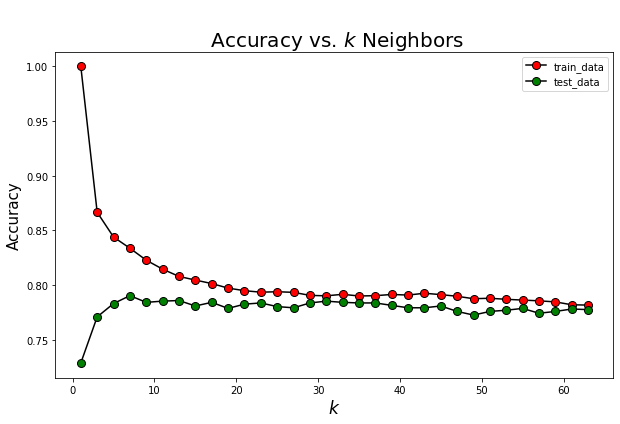

In [75]:
 # Plot ACCURACY performance of KNN

plt.figure(figsize=(10,6))
plt.plot(knn_metrics.k, knn_metrics.train_score, color='black', 
         marker='o',markerfacecolor='red', markersize=8, label = 'train_data')

plt.plot(knn_metrics.k, knn_metrics.test_score, color='black', 
         marker='o',markerfacecolor='green', markersize=8, label = 'test_data')

plt.title('\n Accuracy vs. $k$ Neighbors', size = 20)
plt.xlabel('$k$', size = 17)
plt.ylabel('Accuracy', size = 15)
plt.legend(loc='best')
plt.show()

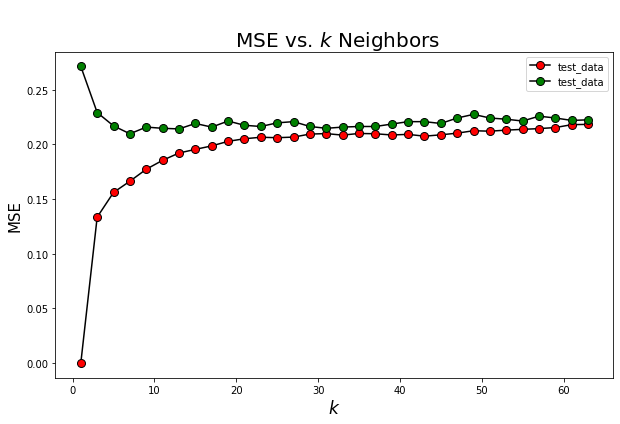

In [76]:
 # Plot MSE performance of KNN

plt.figure(figsize=(10,6))
plt.plot(knn_metrics.k, knn_metrics.train_loss, color='black', 
         marker='o',markerfacecolor='red', markersize=8, label = 'test_data')

plt.plot(knn_metrics.k, knn_metrics.test_loss, color='black', 
         marker='o',markerfacecolor='green', markersize=8, label = 'test_data')

plt.title('\n MSE vs. $k$ Neighbors', size = 20)
plt.xlabel('$k$', size = 17)
plt.ylabel('MSE', size = 15)
plt.legend(loc='best')
plt.show()

In [77]:
# Print best params

max_score = max(knn_metrics.test_score)
mean_score = np.mean(knn_metrics.test_score)
best_k = neighbours[test_score.index(max_score)]

print(f'Max TEST accuracy reached: {max_score}')
print(f'Mean TEST accuracy: {mean_score}')
print(f'Best K value: {best_k}')

Max TEST accuracy reached: 0.7903678054786087
Mean TEST accuracy: 0.7789554959218221
Best K value: 7


<br>

According to cross validation, **the best value of k is around 7**. 

7 is a relatively low value, and low k values usually produce overfitting in KNN models. In these cases, models are more exposed to local anomalies. In fact, optimal k of 7 in this situation reveals evidence of overfitting: accuracy is slightly greater in train set than in test set.

<br>

### Train KNN model

In [78]:
# Apply model in with optimal K in the whole train set

# Instanciate and fit the model
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)

# Perform predictions
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

# Accuracy score
knn_train_acc = accuracy_score(y_train, knn_pred_train)
knn_test_acc = accuracy_score(y_test, knn_pred_test)

# Mean Squared Errors
knn_train_mse = mean_squared_error(y_train, knn_pred_train)
knn_test_mse = mean_squared_error(y_test, knn_pred_test)

print('Accuracy score - train set: ', knn_train_acc)
print('Accuracy score - test set: ', knn_test_acc)
print('MSE - train set: ', knn_train_mse)
print('MSE - test set: ', knn_test_mse)

Accuracy score - train set:  0.8391569606211869
Accuracy score - test set:  0.7960088691796009
MSE - train set:  0.16084303937881309
MSE - test set:  0.2039911308203991


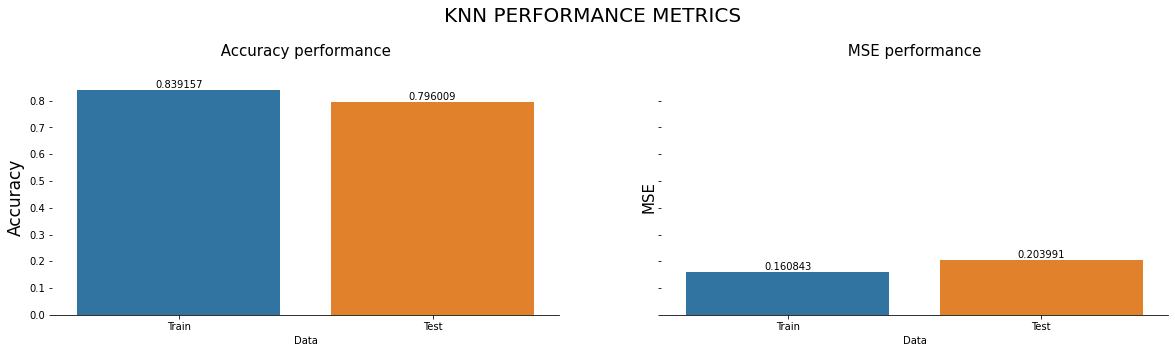

In [79]:
#Plot performance metrics

knn_scores = pd.DataFrame({'Data': ['Train', 'Test'],
                           'Accuracy': [knn_train_acc, knn_test_acc],
                           'MSE': [knn_train_mse, knn_test_mse]})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey = True)

fig.suptitle("KNN PERFORMANCE METRICS", size = 20)
fig.subplots_adjust(top=0.78)

axes[0] = sns.barplot(ax = axes[0], x = knn_scores['Data'], y = knn_scores['Accuracy'], palette="tab10")
axes[0].set_title('\n Accuracy performance \n', fontsize = 15)
axes[0].tick_params(labelsize = 10)
axes[0].set_ylabel('Accuracy', fontsize = 17)

for i in axes[0].containers:
    axes[0].bar_label(i,)

    
axes[1] = sns.barplot(ax = axes[1], x = knn_scores['Data'], y = knn_scores['MSE'], palette="tab10")
axes[1].set_title('\n MSE performance \n', fontsize = 15)
axes[1].tick_params(labelsize = 10, )
axes[1].set_ylabel('MSE', fontsize = 15)

sns.despine(left=True)

for i in axes[1].containers:
    axes[1].bar_label(i,)

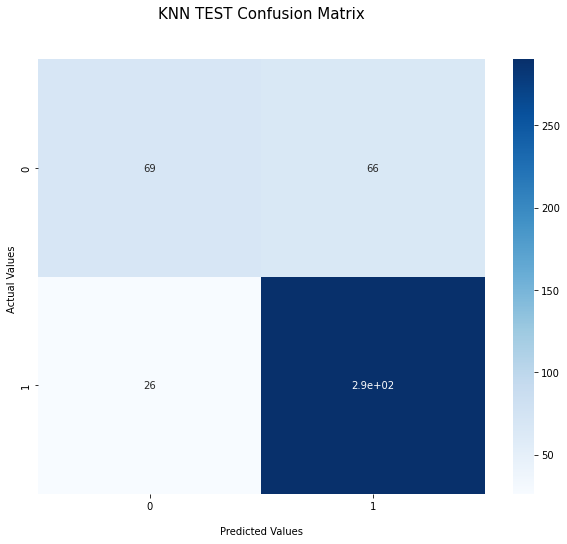

In [80]:
# Confusion matrix

knn_matrix = confusion_matrix(y_test, knn_pred_test)

plt.figure(figsize = (10, 8))
ax = sns.heatmap(knn_matrix, annot = True, cmap = 'Blues')

ax.set_title('KNN TEST Confusion Matrix\n\n', size = 15);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [81]:
# Print classification report

print (classification_report(y_test, knn_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       135
           1       0.81      0.92      0.86       316

    accuracy                           0.80       451
   macro avg       0.77      0.71      0.73       451
weighted avg       0.79      0.80      0.78       451



There are several conclusions that we can reach from this performance:

* There is slight **evidence of overfitting**, the model performs better in train set than in test set. This usually appears in KNN when is used a relatively low k (in this case, 7).
* Although the accuracy of the model reaches almost 80%, the model has a **better performance predicting class 1 (Liberal) than class 0 (other parties)**. While class 1 present a recall metric near 92%, class 0 reaches only 51%. This difference of performance can be observed both in confusion matrix (accuracy) and classification report (recall and precision). This may be a consequence of lack of information (features and observations), or due to the class imbalance.
* In general terms, **we can not conclude that this is a fairly good model for predicting if a POA will be won by Liberals or not.**

## Logistic Regression

### Feature selection and hyperparameter tunning

In [82]:
# Iterate over N features to analyze its inclussion while monitoring accuracy

accuracy_list = []
mse_list = []
n_features = []

for i in range(1, len(X_train.columns)):
    model = LogisticRegression()
    selector = RFE(model, n_features_to_select = i) # Iterate over N of features to analyze accuracy
    selector.fit(X_train, y_train)
    y_predicted_test = selector.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, y_predicted_test))
    mse_list.append(mean_squared_error(y_test, y_predicted_test))
    n_features.append(i)


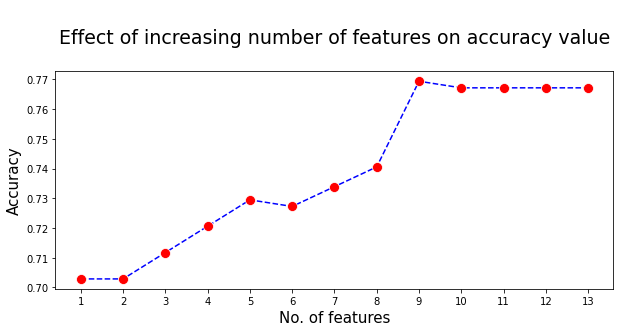

In [83]:
# Plot the relation between N of features and accuracy

acc_df = pd.DataFrame({'accuracy': accuracy_list, 'n_features': n_features})

plt.figure(figsize=(10, 4))
sns.lineplot(x = acc_df['n_features'], y = acc_df['accuracy'], 
             color ='blue', linestyle='dashed', marker='o', 
             markerfacecolor='red', markersize=10)

plt.title('\n Effect of increasing number of features on accuracy value \n', size = 19)
plt.xlabel('No. of features', size = 15)
plt.xticks(range(1, len(X_train.columns)))
plt.ylabel('Accuracy', size = 15)
plt.show()

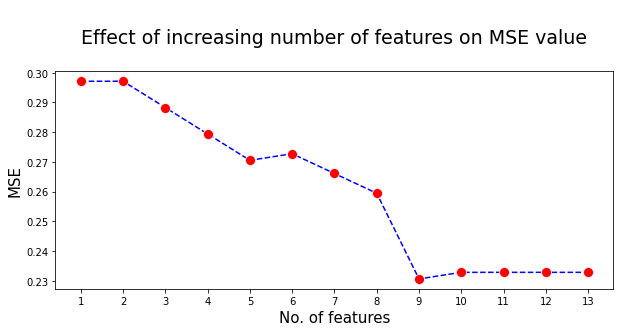

In [84]:
# Plot the relation between N of features and MSE

mse_df = pd.DataFrame({'MSE': mse_list, 'n_features': n_features})

plt.figure(figsize=(10, 4))
sns.lineplot(x = mse_df['n_features'], y = mse_df['MSE'], 
             color ='blue', linestyle='dashed', marker='o', 
             markerfacecolor='red', markersize=10)

plt.title('\n Effect of increasing number of features on MSE value \n', size = 19)
plt.xlabel('No. of features', size = 15)
plt.xticks(range(1, len(X_train.columns)))
plt.ylabel('MSE', size = 15)
plt.show()

In [87]:
# Train model with suggested N and detect most important features

lr_model = LogisticRegression()
selector = RFE(lr_model, n_features_to_select = 9)
selector.fit(X_train, y_train)

# Get most important features
support_var = selector.get_support()
X_train.columns[support_var]

Index(['age_mean', 'Deciles_1_2', 'Deciles_3_4', 'Deciles_9_10',
       'State_and_admin', 'Prof_and_tech', 'Bach_or_higher', 'College_or_less',
       'urban'],
      dtype='object')

<br>

Based on RFE results, **Logistic Regression model will be built over the following features**.:

'age_mean', 'Deciles_1_2', 'Deciles_3_4', 'Deciles_9_10', 'State_and_admin', 'Prof_and_tech', 'Bach_or_higher', 'College_or_less','urban'

<br>

In [89]:
# Select features for Logistic Regression based on RFE

X_train_lr = X_train[['age_mean', 'Deciles_1_2', 'Deciles_3_4', 'Deciles_9_10', 
                      'State_and_admin', 'Prof_and_tech', 'Bach_or_higher', 'College_or_less','urban']]

X_test_lr = X_test[['age_mean', 'Deciles_1_2', 'Deciles_3_4', 'Deciles_9_10', 
                      'State_and_admin', 'Prof_and_tech', 'Bach_or_higher', 'College_or_less','urban']]

In [90]:
# Tune hyperparameter C

param_grid = {"C": np.logspace(-3,3,7)}

lr_cv = LogisticRegression(max_iter = 1000)
lr_cv = GridSearchCV(lr_cv, param_grid, cv = 5)
lr_cv.fit(X_train_lr, y_train)

print("tuned hpyerparameters :(best parameters) ", lr_cv.best_params_)
print("accuracy :", lr_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0}
accuracy : 0.7831409664512157


### Train Logistic Regression model

In [95]:
# Train final model with hyperparameter C and full N of features

log_reg = LogisticRegression(max_iter = 1000, C = 1000)
log_reg.fit(X_train_lr, y_train)


# Perform predictions
lr_train_pred = log_reg.predict(X_train_lr)
lr_test_pred = log_reg.predict(X_test_lr)


### Performance Metrics

In [96]:
# Accuracy score
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

# Mean Squared Errors
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
lr_test_mse = mean_squared_error(y_test, lr_test_pred)

print('Accuracy score - train set: ', lr_train_acc)
print('Accuracy score - test set: ', lr_test_acc)
print('MSE - train set: ', lr_train_mse)
print('MSE - test set: ', lr_test_mse)

Accuracy score - train set:  0.785912368275097
Accuracy score - test set:  0.7782705099778271
MSE - train set:  0.21408763172490294
MSE - test set:  0.22172949002217296


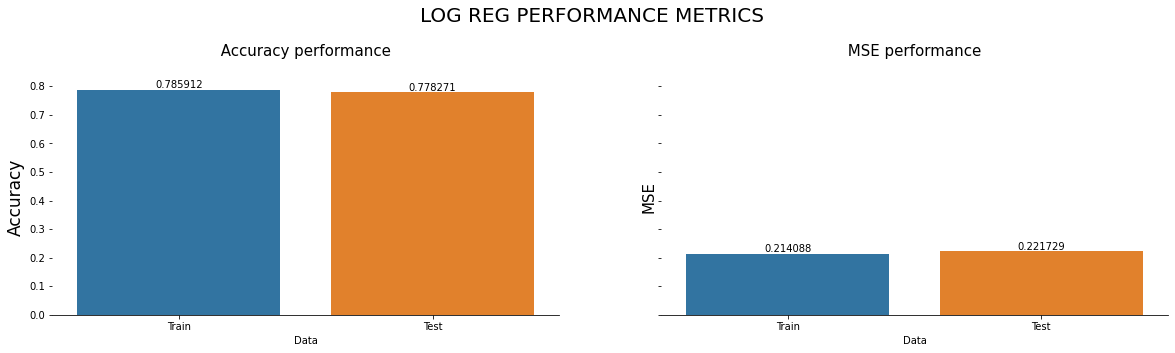

In [97]:
#Plot performance metrics

lr_scores = pd.DataFrame({'Data': ['Train', 'Test'],
                           'Accuracy': [lr_train_acc, lr_test_acc],
                           'MSE': [lr_train_mse, lr_test_mse]})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey = True)

fig.suptitle("LOG REG PERFORMANCE METRICS", size = 20)
fig.subplots_adjust(top=0.78)

axes[0] = sns.barplot(ax = axes[0], x = lr_scores['Data'], y = lr_scores['Accuracy'], palette="tab10")
axes[0].set_title('\n Accuracy performance \n', fontsize = 15)
axes[0].tick_params(labelsize = 10)
axes[0].set_ylabel('Accuracy', fontsize = 17)

for i in axes[0].containers:
    axes[0].bar_label(i,)

    
axes[1] = sns.barplot(ax = axes[1], x = lr_scores['Data'], y = lr_scores['MSE'], palette="tab10")
axes[1].set_title('\n MSE performance \n', fontsize = 15)
axes[1].tick_params(labelsize = 10, )
axes[1].set_ylabel('MSE', fontsize = 15)

sns.despine(left=True)

for i in axes[1].containers:
    axes[1].bar_label(i,)

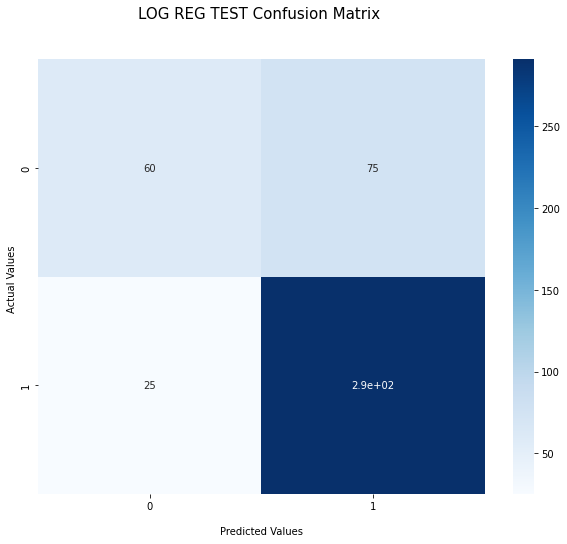

In [98]:
# Confusion Matrix

lr_matrix = confusion_matrix(y_test, lr_test_pred)

plt.figure(figsize = (10, 8))
ax = sns.heatmap(lr_matrix, annot = True, cmap = 'Blues')

ax.set_title('LOG REG TEST Confusion Matrix \n\n', size = 15);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [99]:
# Print classification report

print (classification_report(y_test, lr_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.44      0.55       135
           1       0.80      0.92      0.85       316

    accuracy                           0.78       451
   macro avg       0.75      0.68      0.70       451
weighted avg       0.77      0.78      0.76       451



About logistic regression:

* Shows **less overfitting than KNN**, scores and errors are almost equal.
* Logistic Regression, such as the KNN model, performs better at predicting class 1 than class 0.
* **Classification report shows that performance has even decreased with class 0 predictions**, with nearly 10% less recall than KNN. As with the KNN model, this could be due to class imbalance or features with low predictive potential.
* **We can not conclude that this is a fairly good model for predicting if a POA will be won by Liberals or not.**

## Models vs Baseline

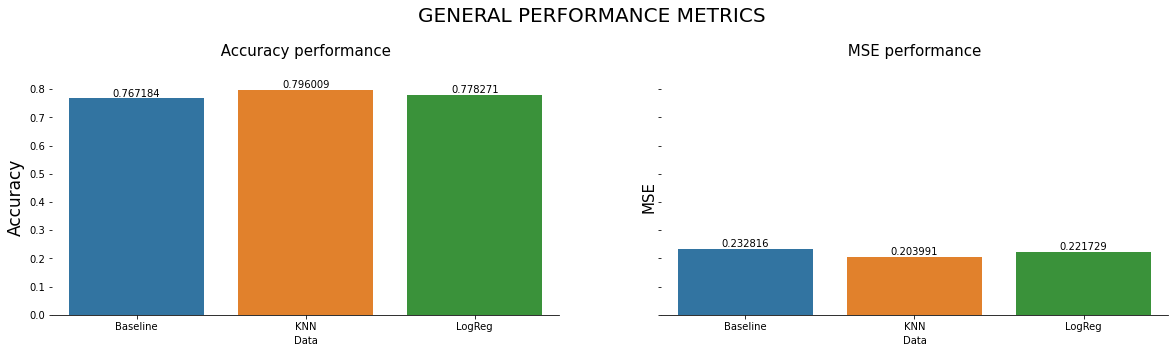

In [100]:
#Plot performance metrics

metrics_comp = pd.DataFrame({'Data': ['Baseline', 'KNN', 'LogReg'],
                           'Accuracy': [base_test_acc, knn_test_acc, lr_test_acc],
                           'MSE': [base_test_mse, knn_test_mse, lr_test_mse]})


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey = True)

fig.suptitle("GENERAL PERFORMANCE METRICS", size = 20)
fig.subplots_adjust(top=0.78)

axes[0] = sns.barplot(ax = axes[0], x = metrics_comp['Data'], y = metrics_comp['Accuracy'], palette="tab10")
axes[0].set_title('\n Accuracy performance \n', fontsize = 15)
axes[0].tick_params(labelsize = 10)
axes[0].set_ylabel('Accuracy', fontsize = 17)

for i in axes[0].containers:
    axes[0].bar_label(i,)

    
axes[1] = sns.barplot(ax = axes[1], x = metrics_comp['Data'], y = metrics_comp['MSE'], palette="tab10")
axes[1].set_title('\n MSE performance \n', fontsize = 15)
axes[1].tick_params(labelsize = 10, )
axes[1].set_ylabel('MSE', fontsize = 15)

sns.despine(left=True)

for i in axes[1].containers:
    axes[1].bar_label(i,)

## KNN vs Logistic Regression

In [102]:
# Model performance comparisson

clf_lr = LogisticRegression(max_iter = 1000, C = 1000)
clf_knn = KNeighborsClassifier(n_neighbors = best_k)

scores_lr = cross_val_score(clf_lr, X, y, scoring = 'accuracy', cv = KFold(n_splits = 5, shuffle = True))
scores_knn = cross_val_score(clf_knn, X, y, scoring = 'accuracy', cv = KFold(n_splits = 5, shuffle = True))

print('Accuracy Logistic Regression', scores_lr.mean())
print('Accuracy KNN', scores_knn.mean())

Accuracy Logistic Regression 0.7803863020448386
Accuracy KNN 0.7897117516629711


In [103]:
from scipy.stats import ttest_ind

t,p = ttest_ind(scores_lr, scores_knn)
print('t-scores p-value: %0.4f %0.4f'% (t, p))

t-scores p-value: -1.0129 0.3407


**T-test demonstrate that there is not enough evidence to conclude that KNN accuracy is higher than Logistic Regression.**

# General conclusion


Although both KNN and Logistic Regression show some improvement in metrics when compared to the baseline model, the improvement is not significant. Furthermore, the accuracy score is close to the distribution of the data values, indicating that the models are weak.

There are two possible explanations for this: 

1. Sociodemographic condition is not enough information to predict liberal vote, and there other factors like, for instance, candidate charisma or geographical data that must be somehow included.
2. In 2019, liberals won in almost 70% of postal areas, for predictive purposes, this produces a relative imbalance dataset. An attempt was made to balance the dataset with the SMOTE library, but affected negatively the classification work.

# Artificial Neural Network

Just to try how a Artificial Neural Network would work with this data.

In [104]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [133]:
def initialize_model():
    
    ### Model architecture
    model = models.Sequential()
    model.add(layers.Dense(50, input_dim = X_train.shape[1], activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    ### Model optimization : Optimizer, loss and metric    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = initialize_model()

In [134]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 32, verbose = 0)

In [135]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
accuracy

0.7871397137641907